# Problem 5: Training a simple chatbot using a seq-to-seq model
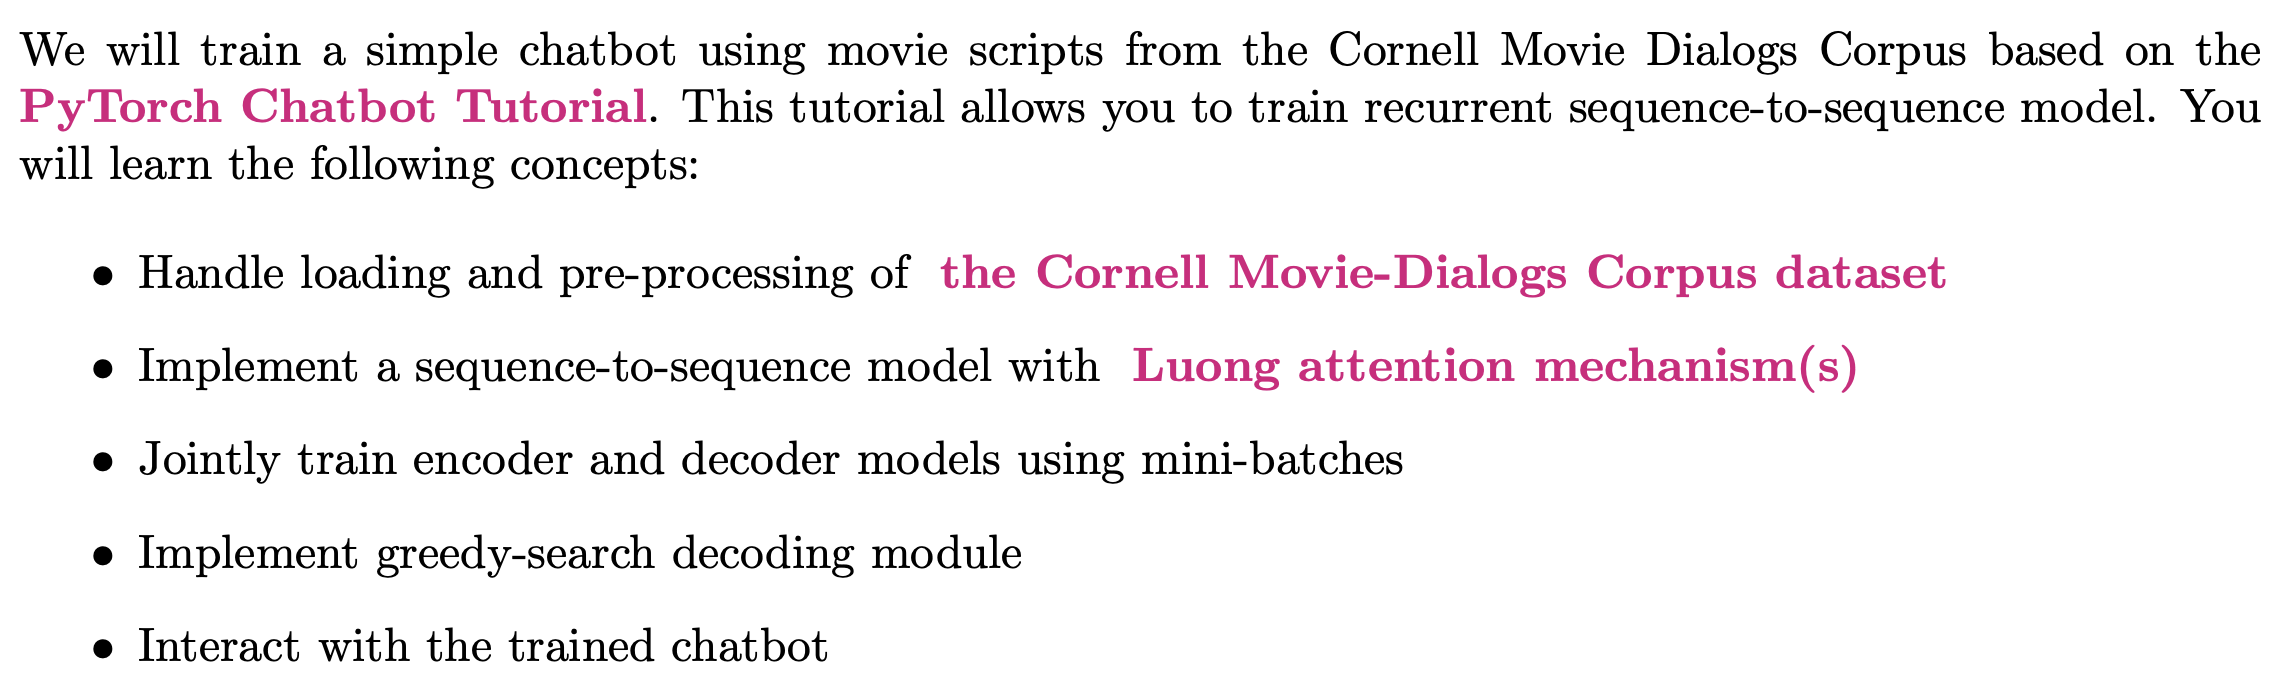
We will use the code in the tutorial as the starting code for the assignment:

### 1. Make a copy of the notebook of the tutorial, follow the instructions to train and evaluate the chatbot model in your local Google Colab environment.

In [1]:
import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import re
import os
import unicodedata
import codecs
from io import open
import itertools
import math
import json


device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
import zipfile
import os
zip_path = "/content/movie-corpus.zip"
extract_path = "data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [4]:
!ls data/movie-corpus/

conversations.json  corpus.json  index.json  speakers.json  utterances.jsonl


In [5]:
corpus_name = "movie-corpus"
corpus = os.path.join("data", corpus_name)

def printLines(file, n=10):
    with open(file, 'rb') as datafile:
        lines = datafile.readlines()
    for line in lines[:n]:
        print(line)

printLines(os.path.join(corpus, "utterances.jsonl"))

b'{"id": "L1045", "conversation_id": "L1044", "text": "They do not!", "speaker": "u0", "meta": {"movie_id": "m0", "parsed": [{"rt": 1, "toks": [{"tok": "They", "tag": "PRP", "dep": "nsubj", "up": 1, "dn": []}, {"tok": "do", "tag": "VBP", "dep": "ROOT", "dn": [0, 2, 3]}, {"tok": "not", "tag": "RB", "dep": "neg", "up": 1, "dn": []}, {"tok": "!", "tag": ".", "dep": "punct", "up": 1, "dn": []}]}]}, "reply-to": "L1044", "timestamp": null, "vectors": []}\n'
b'{"id": "L1044", "conversation_id": "L1044", "text": "They do to!", "speaker": "u2", "meta": {"movie_id": "m0", "parsed": [{"rt": 1, "toks": [{"tok": "They", "tag": "PRP", "dep": "nsubj", "up": 1, "dn": []}, {"tok": "do", "tag": "VBP", "dep": "ROOT", "dn": [0, 2, 3]}, {"tok": "to", "tag": "TO", "dep": "dobj", "up": 1, "dn": []}, {"tok": "!", "tag": ".", "dep": "punct", "up": 1, "dn": []}]}]}, "reply-to": null, "timestamp": null, "vectors": []}\n'
b'{"id": "L985", "conversation_id": "L984", "text": "I hope so.", "speaker": "u0", "meta": {

In [6]:
# Splits each line of the file to create lines and conversations
def loadLinesAndConversations(fileName):
    lines = {}
    conversations = {}
    with open(fileName, 'r', encoding='iso-8859-1') as f:
        for line in f:
            lineJson = json.loads(line)
            # Extract fields for line object
            lineObj = {}
            lineObj["lineID"] = lineJson["id"]
            lineObj["characterID"] = lineJson["speaker"]
            lineObj["text"] = lineJson["text"]
            lines[lineObj['lineID']] = lineObj

            # Extract fields for conversation object
            if lineJson["conversation_id"] not in conversations:
                convObj = {}
                convObj["conversationID"] = lineJson["conversation_id"]
                convObj["movieID"] = lineJson["meta"]["movie_id"]
                convObj["lines"] = [lineObj]
            else:
                convObj = conversations[lineJson["conversation_id"]]
                convObj["lines"].insert(0, lineObj)
            conversations[convObj["conversationID"]] = convObj

    return lines, conversations


# Extracts pairs of sentences from conversations
def extractSentencePairs(conversations):
    qa_pairs = []
    for conversation in conversations.values():
        # Iterate over all the lines of the conversation
        for i in range(len(conversation["lines"]) - 1):  # We ignore the last line (no answer for it)
            inputLine = conversation["lines"][i]["text"].strip()
            targetLine = conversation["lines"][i+1]["text"].strip()
            # Filter wrong samples (if one of the lists is empty)
            if inputLine and targetLine:
                qa_pairs.append([inputLine, targetLine])
    return qa_pairs

In [7]:
# Define path to new file
datafile = os.path.join(corpus, "formatted_movie_lines.txt")

delimiter = '\t'
# Unescape the delimiter
delimiter = str(codecs.decode(delimiter, "unicode_escape"))

# Initialize lines dict and conversations dict
lines = {}
conversations = {}
# Load lines and conversations
print("\nProcessing corpus into lines and conversations...")
lines, conversations = loadLinesAndConversations(os.path.join(corpus, "utterances.jsonl"))

# Write new csv file
print("\nWriting newly formatted file...")
with open(datafile, 'w', encoding='utf-8') as outputfile:
    writer = csv.writer(outputfile, delimiter=delimiter, lineterminator='\n')
    for pair in extractSentencePairs(conversations):
        writer.writerow(pair)

# Print a sample of lines
print("\nSample lines from file:")
printLines(datafile)


Processing corpus into lines and conversations...

Writing newly formatted file...

Sample lines from file:
b'They do to!\tThey do not!\n'
b'She okay?\tI hope so.\n'
b"Wow\tLet's go.\n"
b'"I\'m kidding.  You know how sometimes you just become this ""persona""?  And you don\'t know how to quit?"\tNo\n'
b"No\tOkay -- you're gonna need to learn how to lie.\n"
b"I figured you'd get to the good stuff eventually.\tWhat good stuff?\n"
b'What good stuff?\t"The ""real you""."\n'
b'"The ""real you""."\tLike my fear of wearing pastels?\n'
b'do you listen to this crap?\tWhat crap?\n'
b"What crap?\tMe.  This endless ...blonde babble. I'm like, boring myself.\n"


In [8]:
# Default word tokens
PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token

class Voc:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # Count SOS, EOS, PAD

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # Remove words below a certain count threshold
    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True

        keep_words = []

        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words {} / {} = {:.4f}'.format(
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # Reinitialize dictionaries
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3 # Count default tokens

        for word in keep_words:
            self.addWord(word)

In [9]:
MAX_LENGTH = 10  # Maximum sentence length to consider

# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

# Read query/response pairs and return a voc object
def readVocs(datafile, corpus_name):
    print("Reading lines...")
    # Read the file and split into lines
    lines = open(datafile, encoding='utf-8').\
        read().strip().split('\n')
    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    voc = Voc(corpus_name)
    return voc, pairs

# Returns True if both sentences in a pair 'p' are under the MAX_LENGTH threshold
def filterPair(p):
    # Input sequences need to preserve the last word for EOS token
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH

# Filter pairs using the ``filterPair`` condition
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

# Using the functions defined above, return a populated voc object and pairs list
def loadPrepareData(corpus, corpus_name, datafile, save_dir):
    print("Start preparing training data ...")
    voc, pairs = readVocs(datafile, corpus_name)
    print("Read {!s} sentence pairs".format(len(pairs)))
    pairs = filterPairs(pairs)
    print("Trimmed to {!s} sentence pairs".format(len(pairs)))
    print("Counting words...")
    for pair in pairs:
        voc.addSentence(pair[0])
        voc.addSentence(pair[1])
    print("Counted words:", voc.num_words)
    return voc, pairs


# Load/Assemble voc and pairs
save_dir = os.path.join("data", "save")
voc, pairs = loadPrepareData(corpus, corpus_name, datafile, save_dir)
# Print some pairs to validate
print("\npairs:")
for pair in pairs[:10]:
    print(pair)

Start preparing training data ...
Reading lines...
Read 221282 sentence pairs
Trimmed to 64313 sentence pairs
Counting words...
Counted words: 18082

pairs:
['they do to !', 'they do not !']
['she okay ?', 'i hope so .']
['wow', 'let s go .']
['what good stuff ?', 'the real you .']
['the real you .', 'like my fear of wearing pastels ?']
['do you listen to this crap ?', 'what crap ?']
['well no . . .', 'then that s all you had to say .']
['then that s all you had to say .', 'but']
['but', 'you always been this selfish ?']
['have fun tonight ?', 'tons']


In [10]:
MIN_COUNT = 3    # Minimum word count threshold for trimming

def trimRareWords(voc, pairs, MIN_COUNT):
    # Trim words used under the MIN_COUNT from the voc
    voc.trim(MIN_COUNT)
    # Filter out pairs with trimmed words
    keep_pairs = []
    for pair in pairs:
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True
        # Check input sentence
        for word in input_sentence.split(' '):
            if word not in voc.word2index:
                keep_input = False
                break
        # Check output sentence
        for word in output_sentence.split(' '):
            if word not in voc.word2index:
                keep_output = False
                break

        # Only keep pairs that do not contain trimmed word(s) in their input or output sentence
        if keep_input and keep_output:
            keep_pairs.append(pair)

    print("Trimmed from {} pairs to {}, {:.4f} of total".format(len(pairs), len(keep_pairs), len(keep_pairs) / len(pairs)))
    return keep_pairs


# Trim voc and pairs
pairs = trimRareWords(voc, pairs, MIN_COUNT)

keep_words 7833 / 18079 = 0.4333
Trimmed from 64313 pairs to 53131, 0.8261 of total


In [11]:
def indexesFromSentence(voc, sentence):
    return [voc.word2index[word] for word in sentence.split(' ')] + [EOS_token]


def zeroPadding(l, fillvalue=PAD_token):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

def binaryMatrix(l, value=PAD_token):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

# Returns padded input sequence tensor and lengths
def inputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    padVar = torch.LongTensor(padList)
    return padVar, lengths

# Returns padded target sequence tensor, padding mask, and max target length
def outputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.BoolTensor(mask)
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len

# Returns all items for a given batch of pairs
def batch2TrainData(voc, pair_batch):
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
    inp, lengths = inputVar(input_batch, voc)
    output, mask, max_target_len = outputVar(output_batch, voc)
    return inp, lengths, output, mask, max_target_len


# Example for validation
small_batch_size = 5
batches = batch2TrainData(voc, [random.choice(pairs) for _ in range(small_batch_size)])
input_variable, lengths, target_variable, mask, max_target_len = batches

print("input_variable:", input_variable)
print("lengths:", lengths)
print("target_variable:", target_variable)
print("mask:", mask)
print("max_target_len:", max_target_len)


input_variable: tensor([[  24,   24,   66,   34,  883],
        [  64,  182,  181,    6,   14],
        [ 251, 6690, 1503,    2,    2],
        [  71,   10,   10,    0,    0],
        [  36,    2,    2,    0,    0],
        [ 580,    0,    0,    0,    0],
        [  14,    0,    0,    0,    0],
        [   2,    0,    0,    0,    0]])
lengths: tensor([8, 5, 5, 3, 3])
target_variable: tensor([[  11,  449,   13,   40,  781],
        [  83,  386,    3,   24,  263],
        [  11,   14,  227, 1012,  215],
        [ 381,    2,   14,   44,   14],
        [  14,    0,    2, 1012,    2],
        [   2,    0,    0,   42,    0],
        [   0,    0,    0,   99,    0],
        [   0,    0,    0, 4248,    0],
        [   0,    0,    0,   10,    0],
        [   0,    0,    0,    2,    0]])
mask: tensor([[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True, False,  Tr

In [12]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding

        # Initialize GRU; the input_size and hidden_size parameters are both set to 'hidden_size'
        #   because our input size is a word embedding with number of features == hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):
        # Convert word indexes to embeddings
        embedded = self.embedding(input_seq)
        # Pack padded batch of sequences for RNN module
        packed = nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        # Forward pass through GRU
        outputs, hidden = self.gru(packed, hidden)
        # Unpack padding
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        # Sum bidirectional GRU outputs
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        # Return output and final hidden state
        return outputs, hidden

In [13]:
# Luong attention layer
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))

    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        return torch.sum(hidden * energy, dim=2)

    def concat_score(self, hidden, encoder_output):
        energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        return torch.sum(self.v * energy, dim=2)

    def forward(self, hidden, encoder_outputs):
        # Calculate the attention weights (energies) based on the given method
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        # Transpose max_length and batch_size dimensions
        attn_energies = attn_energies.t()

        # Return the softmax normalized probability scores (with added dimension)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

In [14]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_step, last_hidden, encoder_outputs):
        # Note: we run this one step (word) at a time
        # Get embedding of current input word
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        # Forward through unidirectional GRU
        rnn_output, hidden = self.gru(embedded, last_hidden)
        # Calculate attention weights from the current GRU output
        attn_weights = self.attn(rnn_output, encoder_outputs)
        # Multiply attention weights to encoder outputs to get new "weighted sum" context vector
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        # Concatenate weighted context vector and GRU output using Luong eq. 5
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        # Predict next word using Luong eq. 6
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)
        # Return output and final hidden state
        return output, hidden

In [15]:
def maskNLLLoss(inp, target, mask):
    nTotal = mask.sum()
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, nTotal.item()

In [16]:
def train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding,
          encoder_optimizer, decoder_optimizer, batch_size, clip, max_length=MAX_LENGTH):

    # Zero gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Set device options
    input_variable = input_variable.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)
    # Lengths for RNN packing should always be on the CPU
    lengths = lengths.to("cpu")

    # Initialize variables
    loss = 0
    print_losses = []
    n_totals = 0

    # Forward pass through encoder
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    # Create initial decoder input (start with SOS tokens for each sentence)
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)

    # Set initial decoder hidden state to the encoder's final hidden state
    decoder_hidden = encoder_hidden[:decoder.n_layers]

    # Determine if we are using teacher forcing this iteration
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    # Forward batch of sequences through decoder one time step at a time
    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # Teacher forcing: next input is current target
            decoder_input = target_variable[t].view(1, -1)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # No teacher forcing: next input is decoder's own current output
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal

    # Perform backpropagation
    loss.backward()

    # Clip gradients: gradients are modified in place
    _ = nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    # Adjust model weights
    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / n_totals

In [17]:
def trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer, embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size, print_every, save_every, clip, corpus_name, loadFilename):

    # Load batches for each iteration
    training_batches = [batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_size)])
                      for _ in range(n_iteration)]

    # Initializations
    print('Initializing ...')
    start_iteration = 1
    print_loss = 0
    if loadFilename:
        start_iteration = checkpoint['iteration'] + 1

    # Training loop
    print("Training...")
    for iteration in range(start_iteration, n_iteration + 1):
        training_batch = training_batches[iteration - 1]
        # Extract fields from batch
        input_variable, lengths, target_variable, mask, max_target_len = training_batch

        # Run a training iteration with batch
        loss = train(input_variable, lengths, target_variable, mask, max_target_len, encoder,
                     decoder, embedding, encoder_optimizer, decoder_optimizer, batch_size, clip)
        print_loss += loss

        # Print progress
        if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(iteration, iteration / n_iteration * 100, print_loss_avg))
            print_loss = 0

        # Save checkpoint
        if (iteration % save_every == 0):
            directory = os.path.join(save_dir, model_name, corpus_name, '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size))
            if not os.path.exists(directory):
                os.makedirs(directory)
            torch.save({
                'iteration': iteration,
                'en': encoder.state_dict(),
                'de': decoder.state_dict(),
                'en_opt': encoder_optimizer.state_dict(),
                'de_opt': decoder_optimizer.state_dict(),
                'loss': loss,
                'voc_dict': voc.__dict__,
                'embedding': embedding.state_dict()
            }, os.path.join(directory, '{}_{}.tar'.format(iteration, 'checkpoint')))

In [18]:
class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, input_length, max_length):
        # Forward input through encoder model
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        # Prepare encoder's final hidden layer to be first hidden input to the decoder
        decoder_hidden = encoder_hidden[:self.decoder.n_layers]
        # Initialize decoder input with SOS_token
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        # Initialize tensors to append decoded words to
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_scores = torch.zeros([0], device=device)
        # Iteratively decode one word token at a time
        for _ in range(max_length):
            # Forward pass through decoder
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            # Obtain most likely word token and its softmax score
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            # Record token and score
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            # Prepare current token to be next decoder input (add a dimension)
            decoder_input = torch.unsqueeze(decoder_input, 0)
        # Return collections of word tokens and scores
        return all_tokens, all_scores

In [19]:
def evaluate(encoder, decoder, searcher, voc, sentence, max_length=MAX_LENGTH):
    ### Format input sentence as a batch
    # words -> indexes
    indexes_batch = [indexesFromSentence(voc, sentence)]
    # Create lengths tensor
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    # Transpose dimensions of batch to match models' expectations
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
    # Use appropriate device
    input_batch = input_batch.to(device)
    lengths = lengths.to("cpu")
    # Decode sentence with searcher
    tokens, scores = searcher(input_batch, lengths, max_length)
    # indexes -> words
    decoded_words = [voc.index2word[token.item()] for token in tokens]
    return decoded_words


def evaluateInput(encoder, decoder, searcher, voc):
    input_sentence = ''
    while(1):
        try:
            # Get input sentence
            input_sentence = input('> ')
            # Check if it is quit case
            if input_sentence == 'q' or input_sentence == 'quit': break
            # Normalize sentence
            input_sentence = normalizeString(input_sentence)
            # Evaluate sentence
            output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
            # Format and print response sentence
            output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
            print('Bot:', ' '.join(output_words))

        except KeyError:
            print("Error: Encountered unknown word.")

In [20]:
# Configure models
model_name = 'cb_model'
attn_model = 'dot'
#``attn_model = 'general'``
#``attn_model = 'concat'``
hidden_size = 500
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1
batch_size = 64

# Set checkpoint to load from; set to None if starting from scratch
loadFilename = None
checkpoint_iter = 4000

In [24]:
loadFilename = os.path.join(save_dir, model_name, corpus_name,
                    '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size),
                    '{}_checkpoint.tar'.format(checkpoint_iter))

In [21]:
# Load model if a ``loadFilename`` is provided
loadFilename = False # we don't have loadFilename
if loadFilename:
    # If loading on same machine the model was trained on
    checkpoint = torch.load(loadFilename)
    # If loading a model trained on GPU to CPU
    #checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))
    encoder_sd = checkpoint['en']
    decoder_sd = checkpoint['de']
    encoder_optimizer_sd = checkpoint['en_opt']
    decoder_optimizer_sd = checkpoint['de_opt']
    embedding_sd = checkpoint['embedding']
    voc.__dict__ = checkpoint['voc_dict']


print('Building encoder and decoder ...')
# Initialize word embeddings
embedding = nn.Embedding(voc.num_words, hidden_size)
if loadFilename:
    embedding.load_state_dict(embedding_sd)
# Initialize encoder & decoder models
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
if loadFilename:
    encoder.load_state_dict(encoder_sd)
    decoder.load_state_dict(decoder_sd)
# Use appropriate device
encoder = encoder.to(device)
decoder = decoder.to(device)
print('Models built and ready to go!')

Building encoder and decoder ...
Models built and ready to go!


In [22]:
# Configure training/optimization
clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iteration = 4000
print_every = 1
save_every = 500

# Ensure dropout layers are in train mode
encoder.train()
decoder.train()

# Initialize optimizers
print('Building optimizers ...')
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
if loadFilename:
    encoder_optimizer.load_state_dict(encoder_optimizer_sd)
    decoder_optimizer.load_state_dict(decoder_optimizer_sd)

# If you have an accelerator, configure it to call
for state in encoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)

for state in decoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)

# Run training iterations
print("Starting Training!")
trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,
           embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size,
           print_every, save_every, clip, corpus_name, loadFilename)

Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 1; Percent complete: 0.0%; Average loss: 8.9774
Iteration: 2; Percent complete: 0.1%; Average loss: 8.8472
Iteration: 3; Percent complete: 0.1%; Average loss: 8.6928
Iteration: 4; Percent complete: 0.1%; Average loss: 8.4115
Iteration: 5; Percent complete: 0.1%; Average loss: 8.0025
Iteration: 6; Percent complete: 0.1%; Average loss: 7.4266
Iteration: 7; Percent complete: 0.2%; Average loss: 6.9651
Iteration: 8; Percent complete: 0.2%; Average loss: 6.9737
Iteration: 9; Percent complete: 0.2%; Average loss: 7.0753
Iteration: 10; Percent complete: 0.2%; Average loss: 6.7821
Iteration: 11; Percent complete: 0.3%; Average loss: 6.2915
Iteration: 12; Percent complete: 0.3%; Average loss: 5.6577
Iteration: 13; Percent complete: 0.3%; Average loss: 5.7510
Iteration: 14; Percent complete: 0.4%; Average loss: 5.6396
Iteration: 15; Percent complete: 0.4%; Average loss: 5.6019
Iteration: 16; Percent complete: 0.4%

In [23]:
# Set dropout layers to ``eval`` mode
encoder.eval()
decoder.eval()

# Initialize search module
searcher = GreedySearchDecoder(encoder, decoder)

# Begin chatting (uncomment and run the following line to begin)
# evaluateInput(encoder, decoder, searcher, voc)

### 2. Learn how to use Weights and Biases (W&B) to run a hyperparameter sweep and instrument the notebook to use the Weights and Bias integration to help you run some hyperparameters sweeps in the next steps. Watch the video tutorial provided in the reference section.

In [24]:
!pip install wandb

In [25]:
import wandb
wandb.login()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mis2840 (mis2840-columbia-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

### 3. Create a sweep configuration using the W&B Random Search Strategy for the following hyperparameters:
- Learning rate: [0.0001, 0.00025, 0.0005, 0.001]
- Optimizer: [adam, sgd]
- Clip: [0, 25, 50, 100]
- teacher forcing ratio: [0, 0.5, 1.0]
- decoder learning ratio: [1.0, 3.0, 5.0, 10.0]

In [26]:
sweep_config = {
    "name": "chatbot_hw1",
    "method": "random", # Random Search
    "metric": {
        # "name": "val_loss",
        "name": "train_loss",
        "goal": "minimize"
    },
    "parameters": {
        "learning_rate": {
            "values": [0.0001, 0.00025, 0.0005, 0.001]
        },
        "optimizer": {
            "values": ["adam", "sgd"]
        },
        "clip": {
            "values": [0, 25, 50, 100]
        },
        "teacher_forcing_ratio": {
            "values": [0, 0.5, 1.0]
        },
        "decoder_learning_ratio": {
            "values": [1.0, 3.0, 5.0, 10.0]
        }
    }
}

In [27]:
sweep_id = wandb.sweep(sweep=sweep_config, project="LLMchatbot-HW1")
print("sweep_id:", sweep_id)

Create sweep with ID: exa9yho1
Sweep URL: https://wandb.ai/mis2840-columbia-university/LLMchatbot-HW1/sweeps/exa9yho1
sweep_id: exa9yho1


### 4. Run your hyperparameter sweeps using the GPU-enabled Colab and observe the results in the W&B console

In [28]:
def _make_optimizer(params, name: str, lr: float):
    name = name.lower()
    if name == "adam":
        return torch.optim.Adam(params, lr=lr)
    elif name == "sgd":
        return torch.optim.SGD(params, lr=lr, momentum=0.9)
    else:
        raise ValueError(f"Unknown optimizer: {name}")

def _batch_iter(pairs_list, batch_size):
    while True:
        batch_pairs = [random.choice(pairs_list) for _ in range(batch_size)]
        yield batch2TrainData(voc, batch_pairs)

train_batches = _batch_iter(pairs, batch_size)

def train_entry():
    with wandb.init(project="LLMchatbot-HW1") as run:
        cfg = wandb.config

        embedding = nn.Embedding(voc.num_words, hidden_size)
        encoder   = EncoderRNN(hidden_size, embedding,
                               encoder_n_layers, dropout)
        decoder   = LuongAttnDecoderRNN(attn_model, embedding, hidden_size,
                                        voc.num_words, decoder_n_layers, dropout)

        encoder = encoder.to(device)
        decoder, embedding = decoder.to(device), embedding.to(device)

        base_lr = float(cfg.learning_rate)
        enc_opt = _make_optimizer(encoder.parameters(), cfg.optimizer, base_lr)
        dec_opt = _make_optimizer(decoder.parameters(), cfg.optimizer,
                                  base_lr * float(cfg.decoder_learning_ratio))

        total_iters   = 2000
        log_every     = 200
        print_every   = 500
        print_loss_tot = 0.0

        for it in range(1, total_iters + 1):
            input_var, lengths, target_var, mask, max_target_len = next(train_batches)

            loss = train(
                input_var, lengths, target_var, mask, max_target_len, encoder,
                decoder, embedding, enc_opt, dec_opt,batch_size, cfg.clip)

            loss_val = float(loss)
            print_loss_tot += loss_val

            if it % log_every == 0:
                wandb.log({"iteration": it, "step_loss": loss_val})

            if it % print_every == 0:
                avg = print_loss_tot / print_every
                wandb.log({
                    "iteration": it,
                    "train_loss": avg,
                    "train_ppl": float(math.exp(avg)) if avg < 50 else float("inf")
                })
                print_loss_tot = 0.0


In [29]:
wandb.agent(sweep_id, function=train_entry, count=10)

wandb: Agent Starting Run: 4c5jbkcl with config:
wandb: 	clip: 100
wandb: 	decoder_learning_ratio: 3
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd
wandb: 	teacher_forcing_ratio: 0.5


iteration,▁▂▂▃▃▄▄▅▆▆▆▇██
step_loss,█▄▄▃▅▅▂▃▁▂
train_loss,█▃▂▁
train_ppl,█▃▂▁
iteration,2000
step_loss,3.95724
train_loss,3.94241
train_ppl,51.54291


wandb: Agent Starting Run: jh9qqxng with config:
wandb: 	clip: 50
wandb: 	decoder_learning_ratio: 3
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd
wandb: 	teacher_forcing_ratio: 0


iteration,▁▂▂▃▃▄▄▅▆▆▆▇██
step_loss,█▅▆▅▃▃▃▂▁▁
train_loss,█▃▂▁
train_ppl,█▃▂▁
iteration,2000
step_loss,3.81389
train_loss,3.94994
train_ppl,51.9323


wandb: Agent Starting Run: vk6k3zjz with config:
wandb: 	clip: 100
wandb: 	decoder_learning_ratio: 5
wandb: 	learning_rate: 0.00025
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0


iteration,▁▂▂▃▃▄▄▅▆▆▆▇██
step_loss,▇█▄▅▃▅▄▃▃▁
train_loss,█▄▃▁
train_ppl,█▃▂▁
iteration,2000
step_loss,2.61319
train_loss,2.93244
train_ppl,18.77347


wandb: Agent Starting Run: jgjqur7t with config:
wandb: 	clip: 0
wandb: 	decoder_learning_ratio: 1
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	teacher_forcing_ratio: 0


iteration,▁▂▂▃▃▄▄▅▆▆▆▇██
step_loss,▁▄▃▅▃▁▃▅▇█
train_loss,█▄▁▂
train_ppl,█▄▁▂
iteration,2000
step_loss,8.9807
train_loss,8.97667
train_ppl,7916.20751


wandb: Agent Starting Run: yqugryez with config:
wandb: 	clip: 0
wandb: 	decoder_learning_ratio: 10
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd
wandb: 	teacher_forcing_ratio: 1


iteration,▁▂▂▃▃▄▄▅▆▆▆▇██
step_loss,▆▅▆▇▄▆▃▅█▁
train_loss,▄█▁▄
train_ppl,▄█▁▄
iteration,2000
step_loss,8.96856
train_loss,8.97413
train_ppl,7896.1676


wandb: Agent Starting Run: nkivvnco with config:
wandb: 	clip: 50
wandb: 	decoder_learning_ratio: 5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	teacher_forcing_ratio: 0.5


iteration,▁▂▂▃▃▄▄▅▆▆▆▇██
step_loss,█▆▇▅▂▅▂▃▁▁
train_loss,█▃▂▁
train_ppl,█▂▂▁
iteration,2000
step_loss,3.59201
train_loss,3.60307
train_ppl,36.71088


wandb: Agent Starting Run: rvongw2w with config:
wandb: 	clip: 0
wandb: 	decoder_learning_ratio: 1
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd
wandb: 	teacher_forcing_ratio: 0


iteration,▁▂▂▃▃▄▄▅▆▆▆▇██
step_loss,▇▆▆▆▇▆▄█▁▅
train_loss,▇▅█▁
train_ppl,▇▅█▁
iteration,2000
step_loss,8.94577
train_loss,8.94695
train_ppl,7684.44679


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: s1ah3a94 with config:
wandb: 	clip: 100
wandb: 	decoder_learning_ratio: 10
wandb: 	learning_rate: 0.00025
wandb: 	optimizer: sgd
wandb: 	teacher_forcing_ratio: 0


iteration,▁▂▂▃▃▄▄▅▆▆▆▇██
step_loss,█▇▅▄▆▄▁▄▁▂
train_loss,█▃▂▁
train_ppl,█▂▂▁
iteration,2000
step_loss,3.7517
train_loss,3.77714
train_ppl,43.69086


wandb: Agent Starting Run: nx1mqmcf with config:
wandb: 	clip: 25
wandb: 	decoder_learning_ratio: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.5


iteration,▁▂▂▃▃▄▄▅▆▆▆▇██
step_loss,█▆▆▄▅▅▂▁▃▁
train_loss,█▄▂▁
train_ppl,█▃▂▁
iteration,2000
step_loss,3.06124
train_loss,3.22457
train_ppl,25.14287


wandb: Agent Starting Run: 8nkjjk74 with config:
wandb: 	clip: 0
wandb: 	decoder_learning_ratio: 10
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.5


iteration,▁▂▂▃▃▄▄▅▆▆▆▇██
step_loss,▁▅▄▇▆▆▇▆▆█
train_loss,▁▁█▇
train_ppl,▁▁█▇
iteration,2000
step_loss,8.97089
train_loss,8.97032
train_ppl,7866.13325


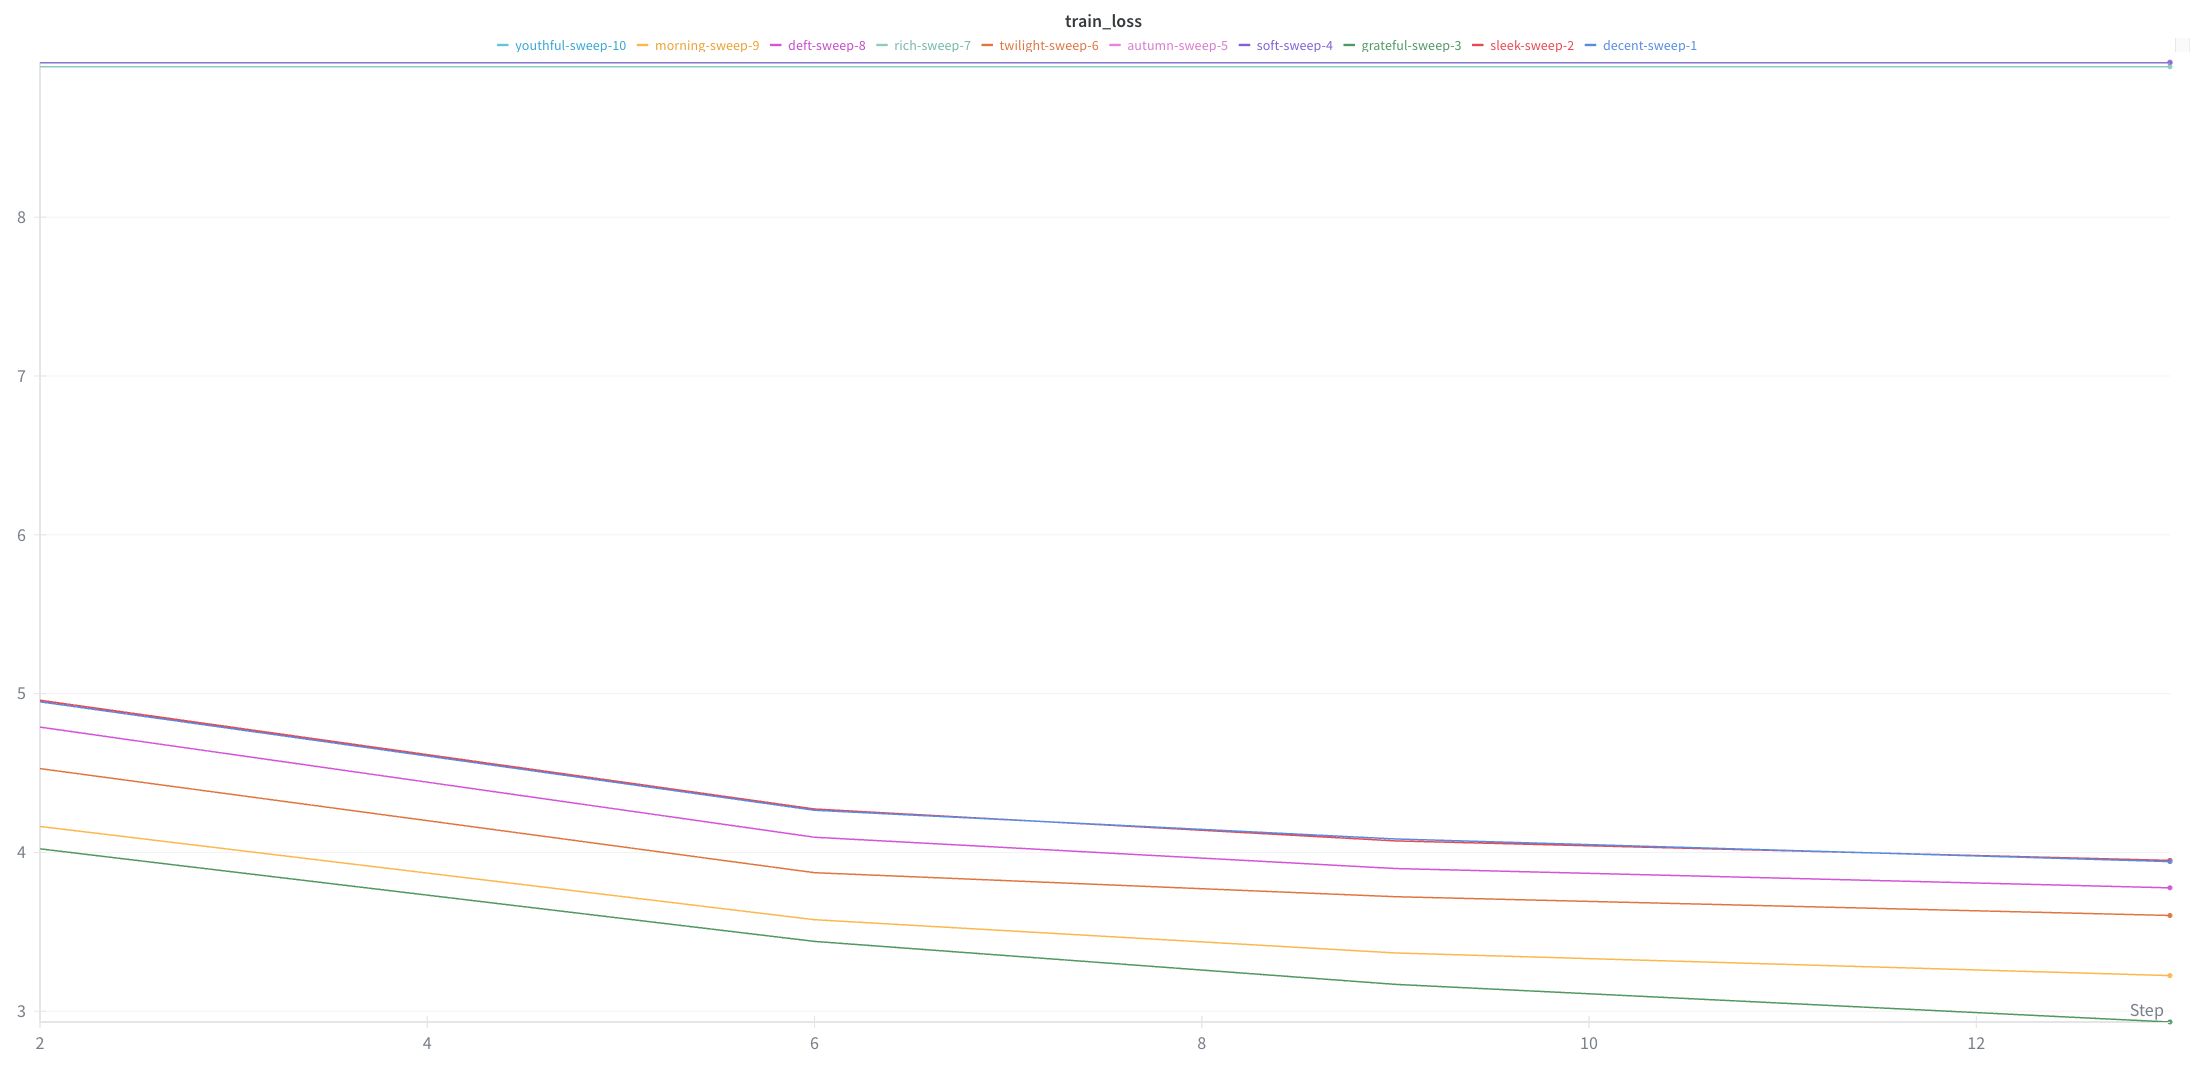

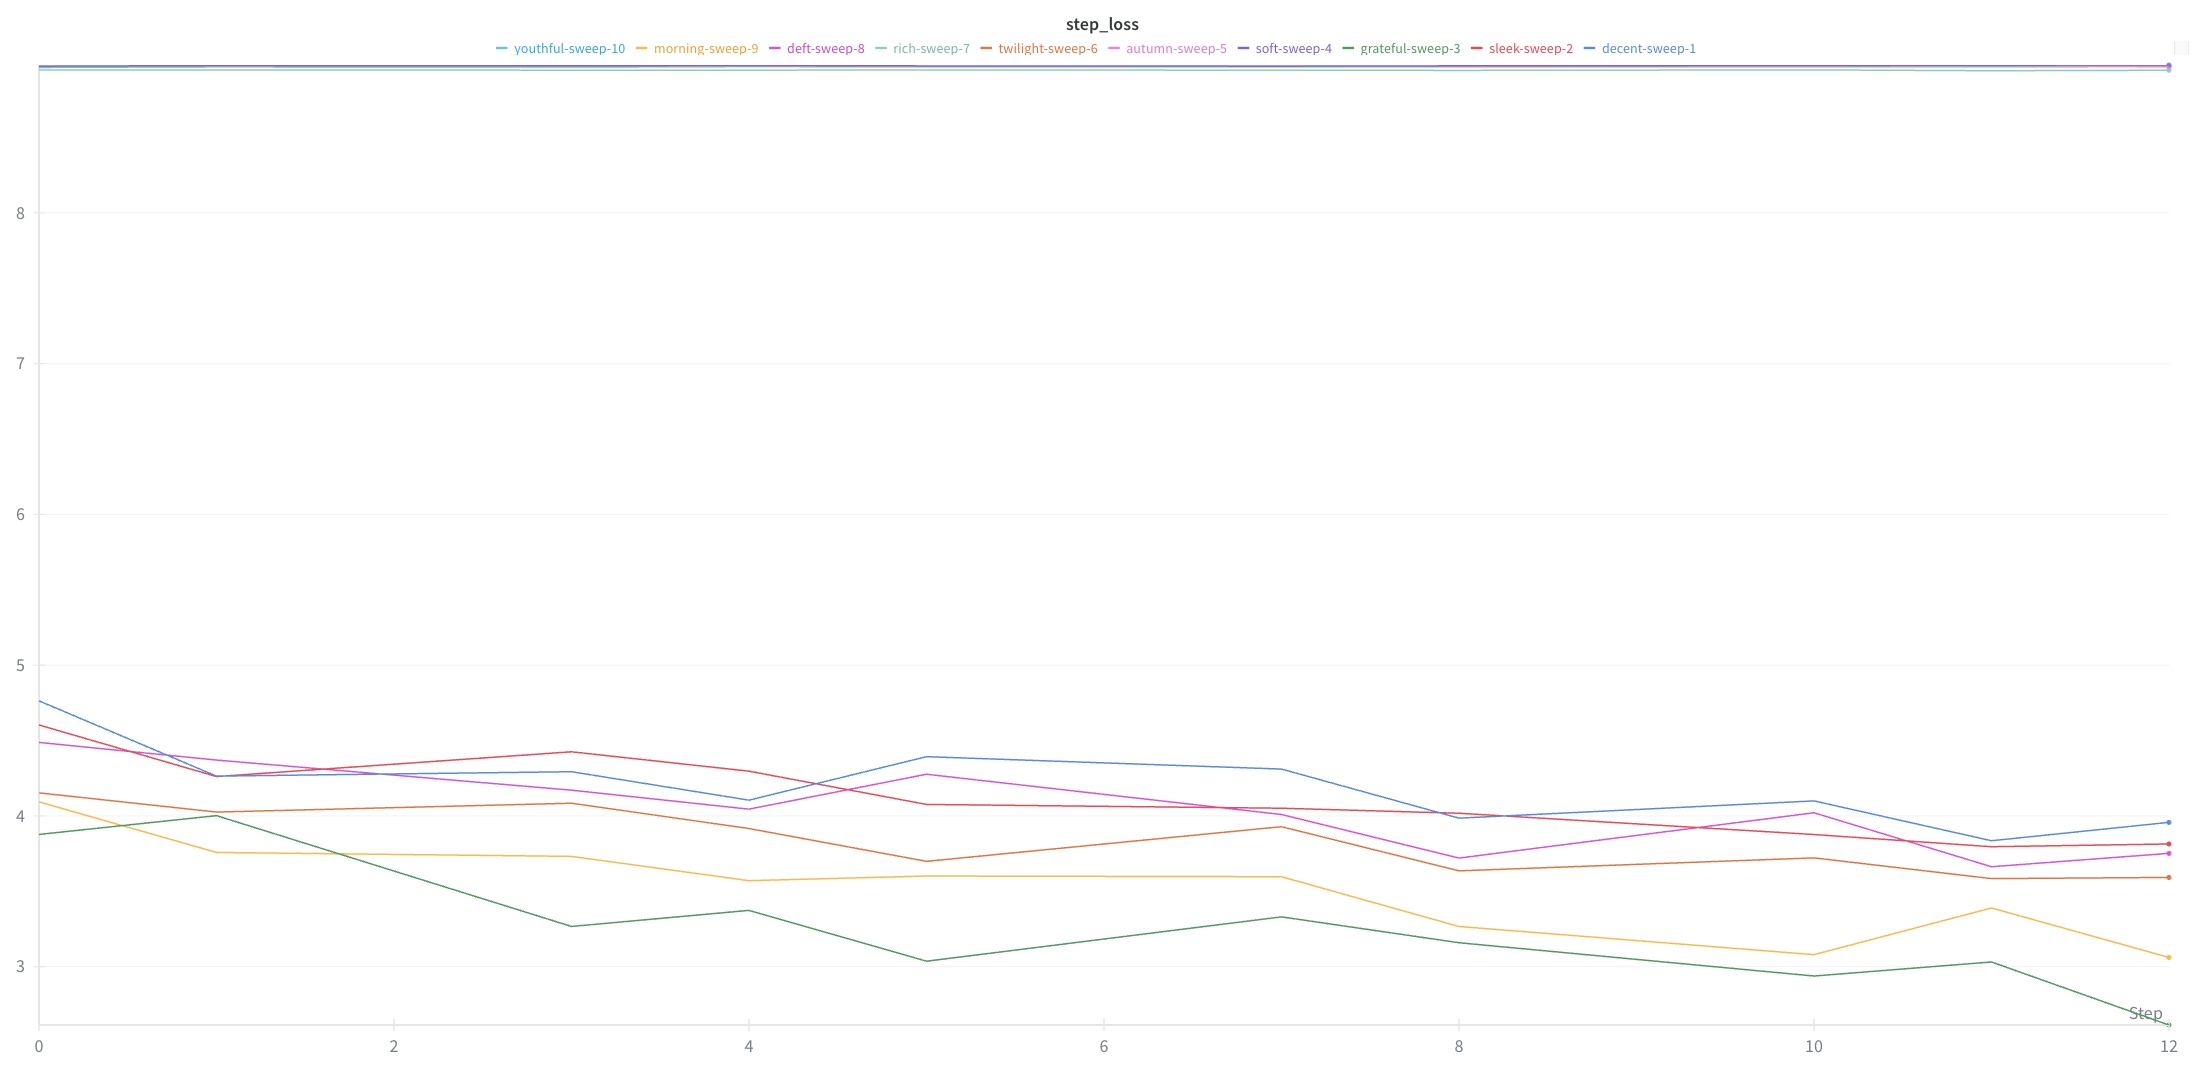

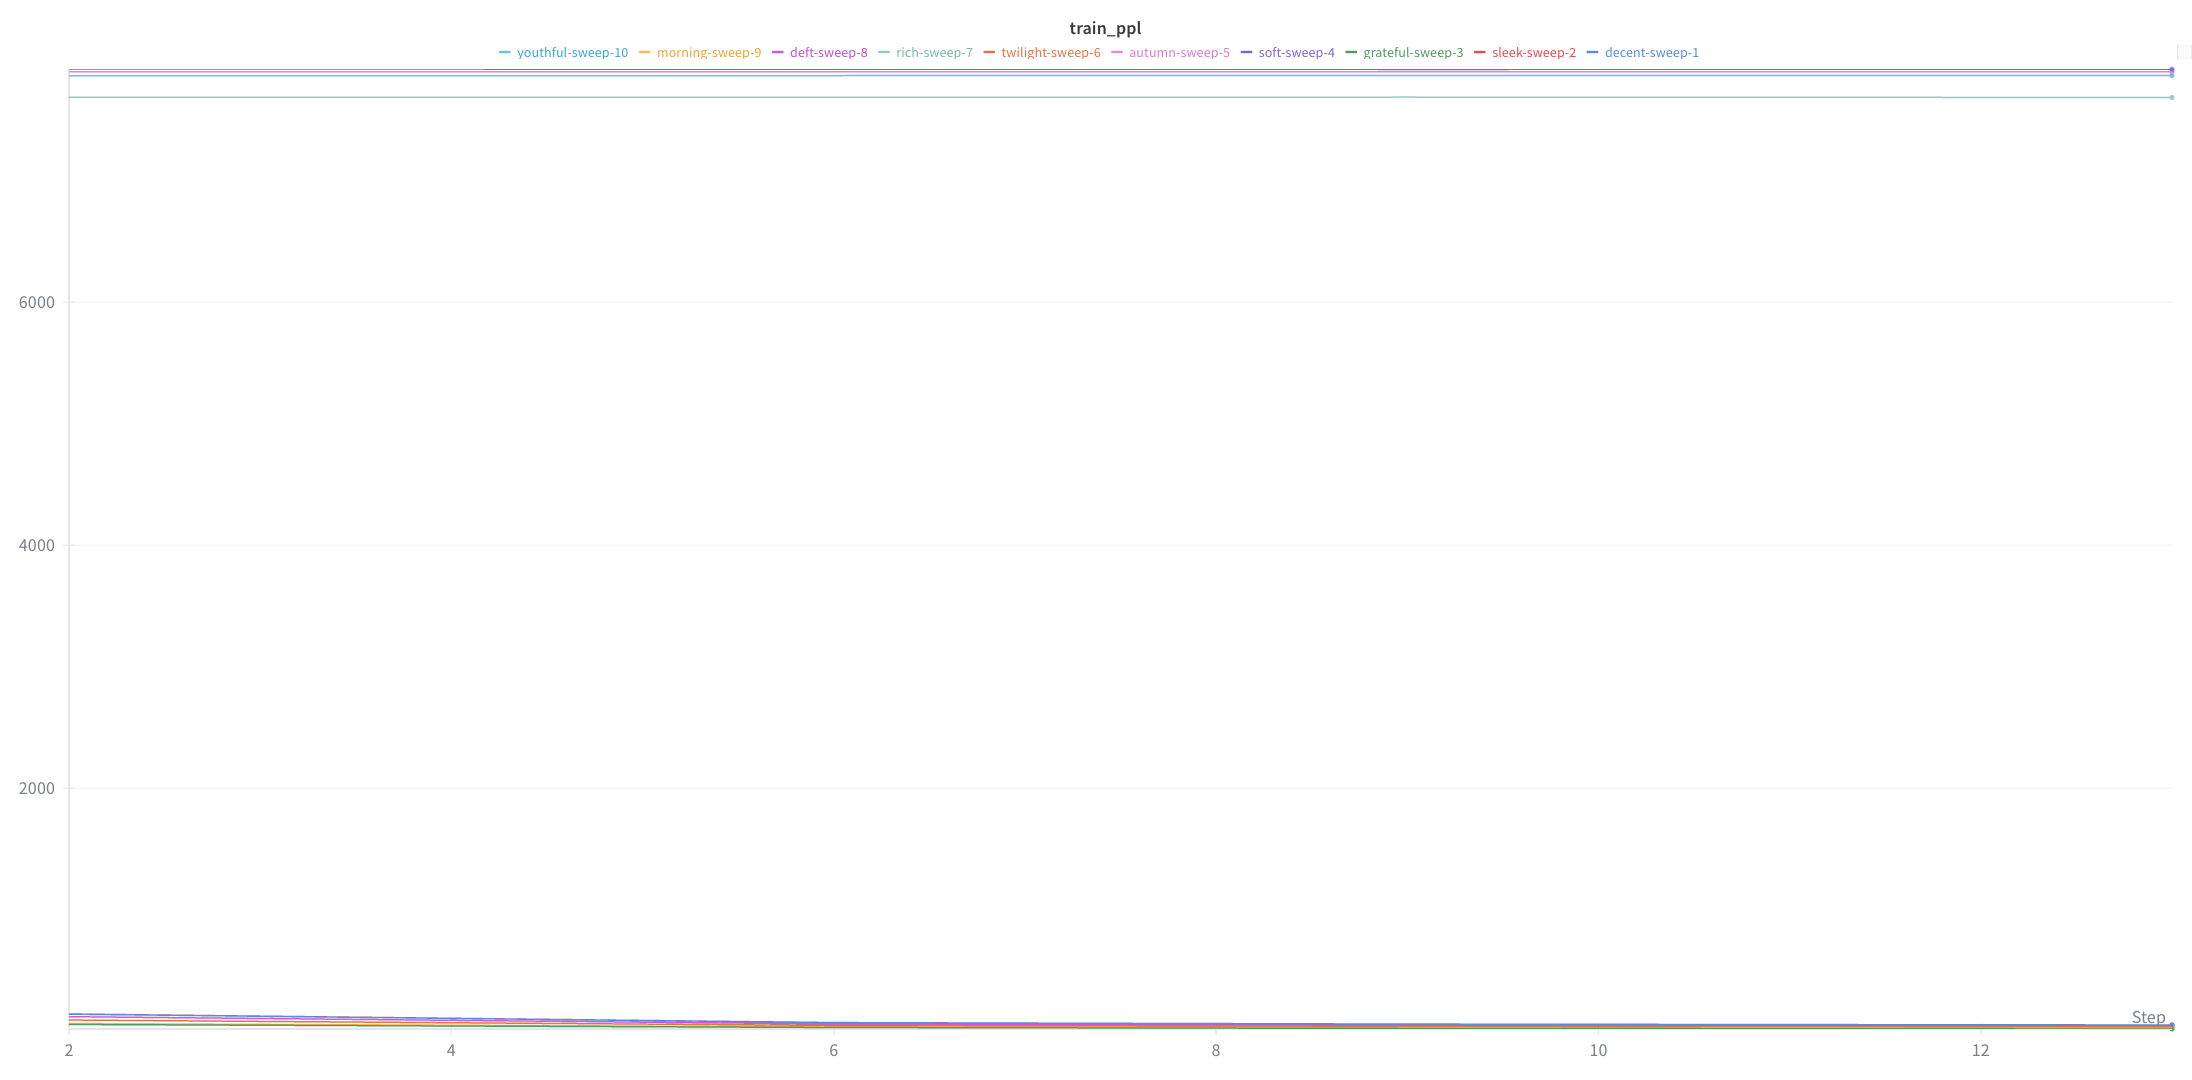

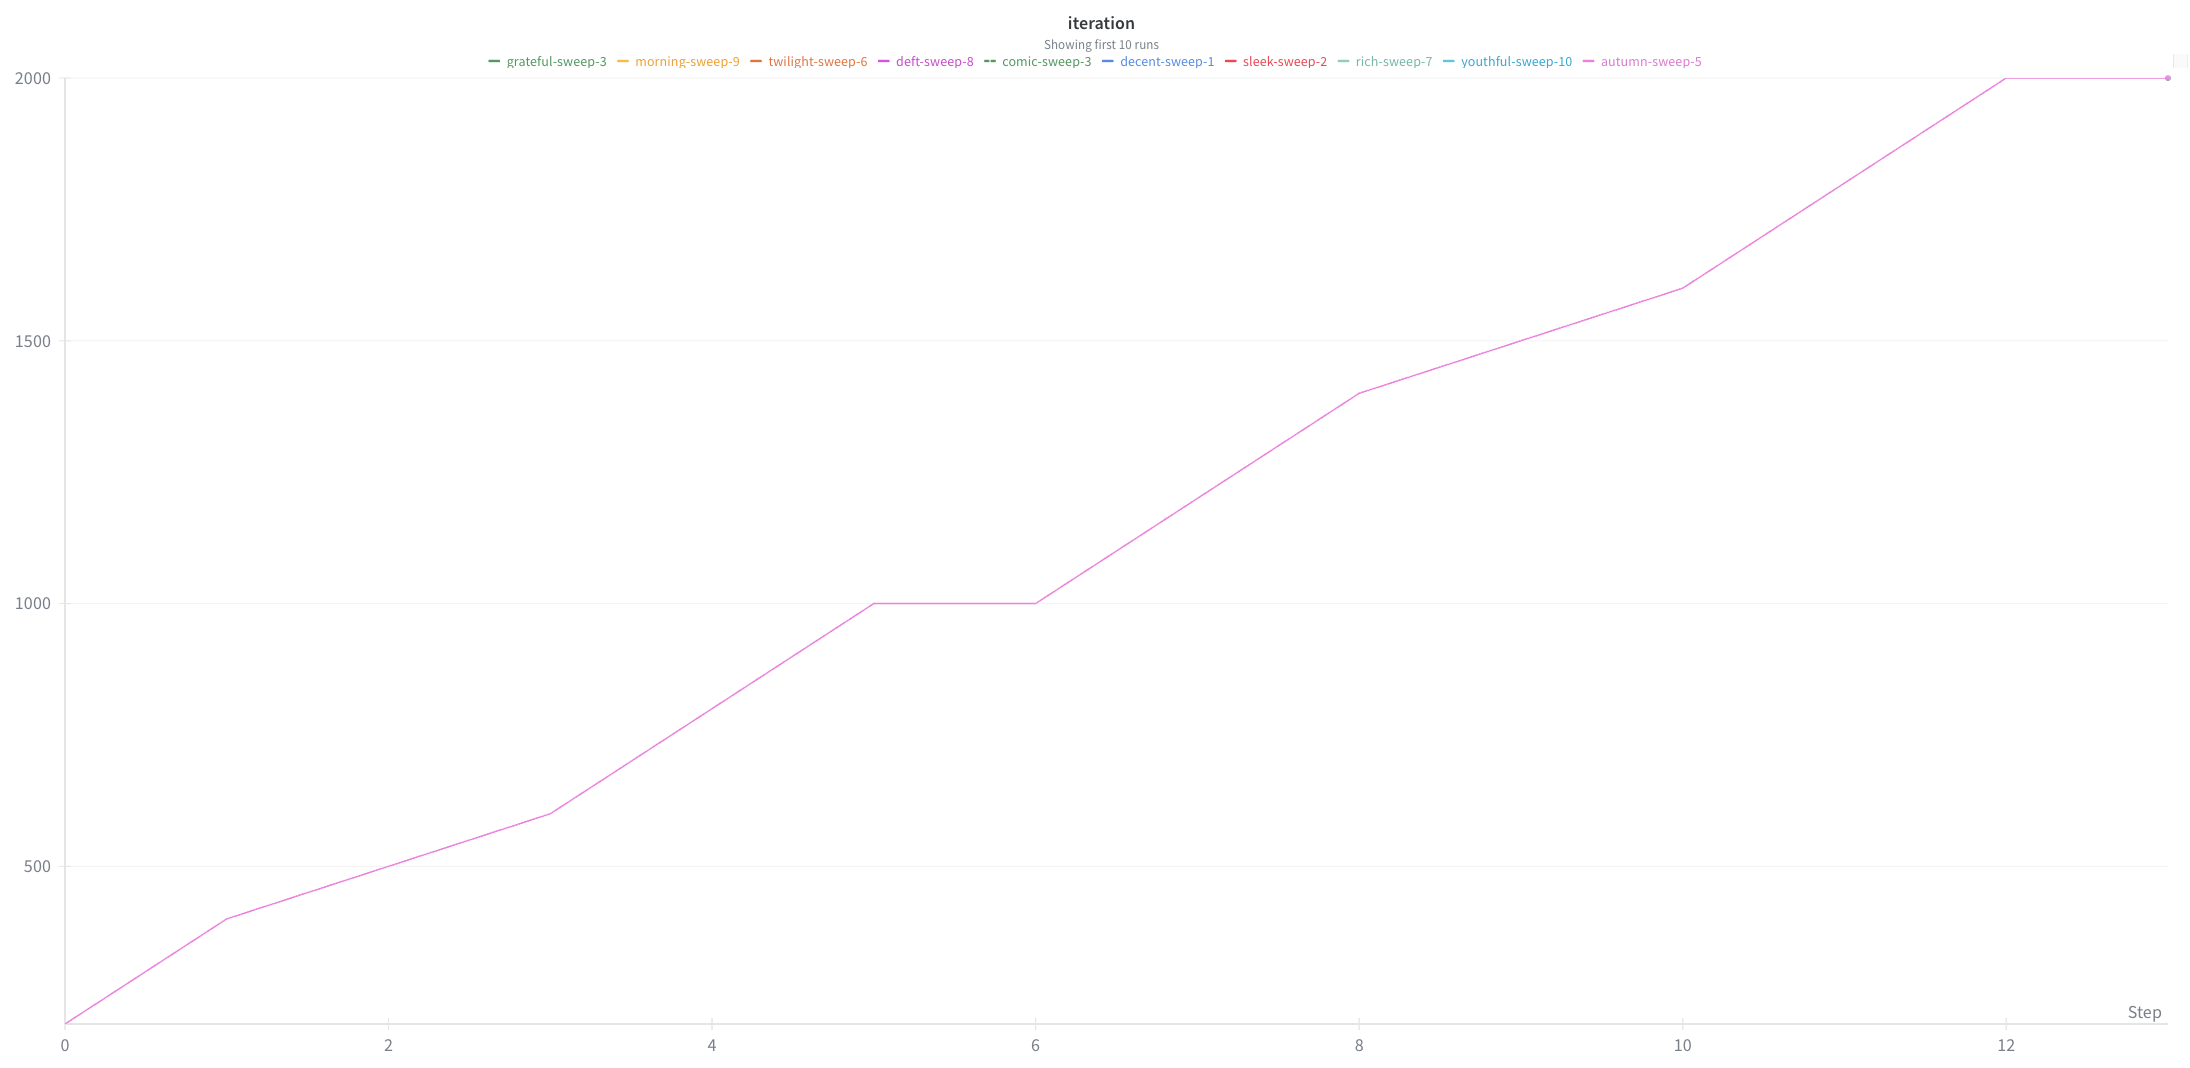

From the train_loss plot, all runs decline, but at the final logged step the **green curve** (**grateful-sweep-3**) reaches the lowest value. The step_loss plot shows the same run is consistently lower with smaller variance, indicating more stable training. Therefore, the best run by minimum train_loss is grateful-sweep-3. The train_ppl plot is simply exp(train_loss), so differences look muted even though the ranking mirrors train_loss. Since no validation set was used, these observations do not guarantee generalization.

### 5. Extract the values of the hyperparameters that give the best results (Minimum loss of the trained model). Explain which hyperparameters affect the model convergence. Use the feature importance of W&B to help guide your analysis.

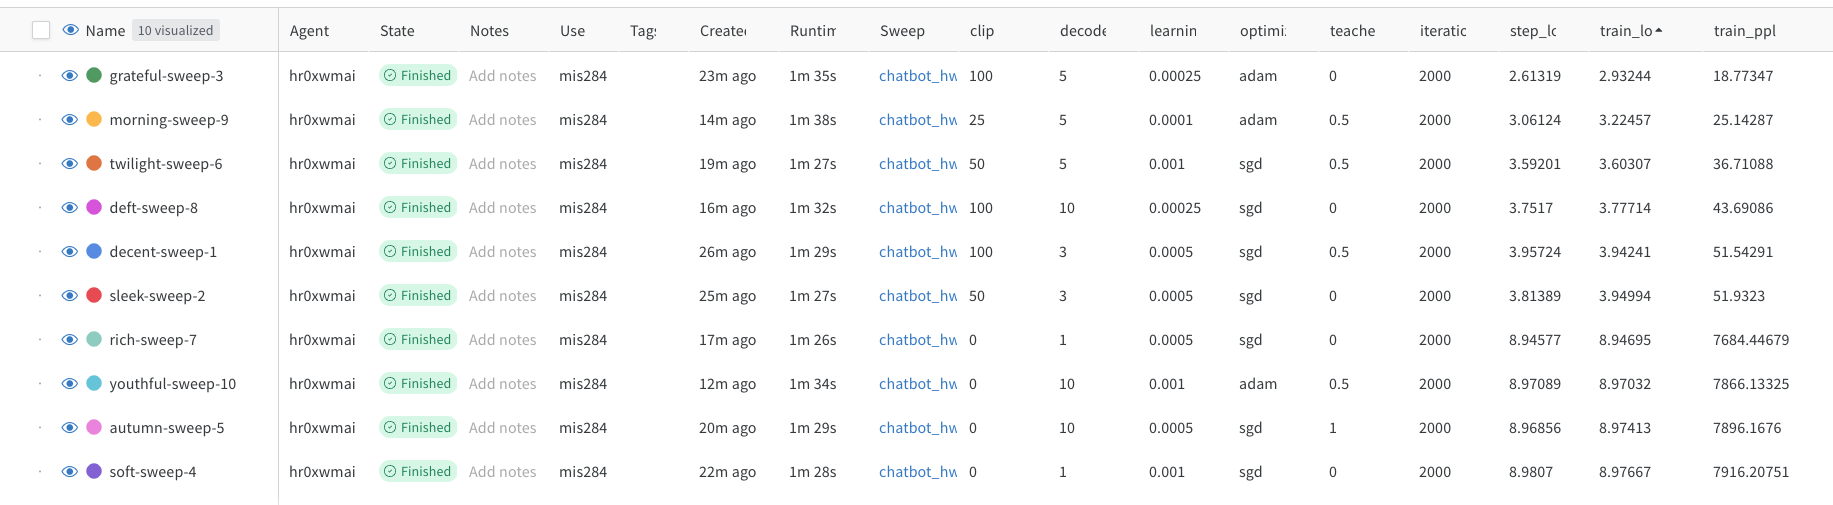

All runs finished and reached the target iterations. Sorting the Runs table by train_loss shows the best run is **grateful-sweep-3** with:
- clip: 100
- decoder_learning_ratio: 5
- learning_rate: 0.00025
- optimizer: adam
- teacher_forcing_ratio: 0

For context, this run’s metrics were roughly step_loss=2.61, train_loss=2.93, train_ppl=18.77, the lowest among the tested settings.

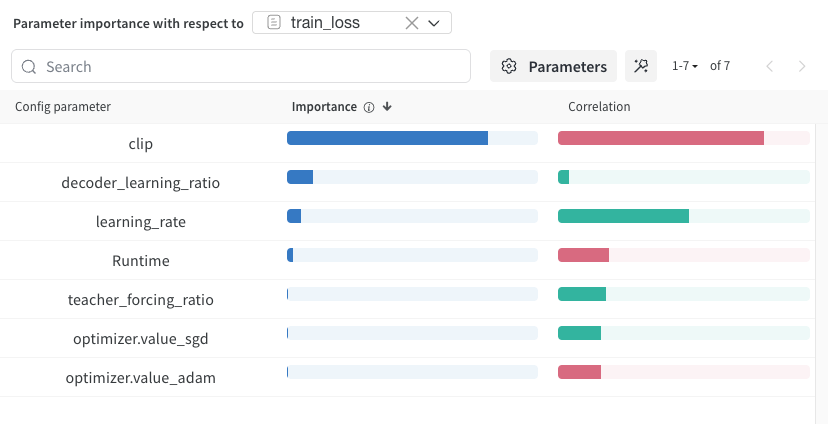

Based on the feature-importance panel (metric: train_loss):

**clip** had the strongest effect on model convergence, followed next by **decoder_learning_ratio** and **learning_rate**.

1. Clip: Within our range, larger thresholds (>=50, especially 100) led to lower loss. Very tight clipping shrinks the effective step size, while a higher threshold avoids unnecessary clipping.
2. Decoder learning ratio: A higher decoder learning ratio (5) improved convergence. Because the decoder is learned from scratch, faster updates would be helpful.
3. Learning rate: With a fixed iteration budget, a mid-low value (2.5e-4) worked better than very low (1e-4) or high (1e-3).

Teacher forcing ratio showed little importance in this sweep. A value of 1.0 can artificially lower train loss, but here the best run still occurred with teacher_forcing_ratio = 0.

# Problem 6: Paper Reading and Analysis

## Paper: Retrival-Augmented Generation for Knowledge-Intensive NLP Tasks
### 1. Main Contribution Analysis
The authors present RAG, a framework that links a parametric generator (BART) with a non-parametric retriever (DPR over Wikipedia). Both parts are trained jointly without explicit supervision, and they introduce two approaches: RAG-Sequence and RAG-Token, which differ in how retrieved documents are used. The system reaches state-of-the-art results on open-domain QA and produces answers that are more factual and specific than BART alone. A notable strength is the ability to swap retrieval indexes to update knowledge. This work offers a practical way to reduce hallucination in language models.

### 2. Personal Learning Relection
Previously, I thought RAG relied only on similarity-based ranking of documents. Reading this paper, I learned that RAG treats retrieved passages as latent variables and trains the generator and query encoder jointly without direct supervision, which was new to me. This deepened my understanding of how retrieval can reduce hallucination, one of the main issues in large language models. I also found it very practical that the model can update its knowledge simply by swapping the index, without retraining. For me, this shows an efficient and important way to keep large models useful over time.

### 3. Brainstorming Proposal
One extension is to expand RAG beyond Wikipedia text by integrating images or graphs as non-parametric memory, enabling multimodal reasoning. As an alternative, RAG could replace the text index with a knowledge graph, so the system retrieves entities and relations for structured reasoning. For applications, I think RAG could be very useful in education. By indexing textbooks or lecture notes, students could ask questions while studying for exams and get clear explanations or summaries. This would make self-study more efficient and help avoid misunderstandings of difficult topics.